In [0]:
from google.colab import drive
drive.mount('/content/gdrive')



Mounted at /content/gdrive


In [0]:

!cp '/content/gdrive/My Drive/FUMPE.zip' '/content'

In [0]:
drive.flush_and_unmount()

In [0]:
# rm -r 'test'

In [0]:

![ ! -d '/content/dataset_compressed' ] && mkdir '/content/dataset_compressed'

In [0]:

!unzip  FUMPE.zip -d /content/dataset_compressed/FUMPE

Archive:  FUMPE.zip
  inflating: /content/dataset_compressed/FUMPE/GroundTruth.rar  
  inflating: /content/dataset_compressed/FUMPE/PAT001.rar  
  inflating: /content/dataset_compressed/FUMPE/PAT002.rar  
  inflating: /content/dataset_compressed/FUMPE/PAT003.rar  
  inflating: /content/dataset_compressed/FUMPE/PAT004.rar  
  inflating: /content/dataset_compressed/FUMPE/PAT005.rar  
  inflating: /content/dataset_compressed/FUMPE/PAT006.rar  
  inflating: /content/dataset_compressed/FUMPE/PAT007.rar  
  inflating: /content/dataset_compressed/FUMPE/PAT008.rar  
  inflating: /content/dataset_compressed/FUMPE/PAT009.rar  
  inflating: /content/dataset_compressed/FUMPE/PAT010.rar  
  inflating: /content/dataset_compressed/FUMPE/PAT011.rar  
  inflating: /content/dataset_compressed/FUMPE/PAT012.rar  
  inflating: /content/dataset_compressed/FUMPE/PAT013.rar  
  inflating: /content/dataset_compressed/FUMPE/PAT014.rar  
  inflating: /content/dataset_compressed/FUMPE/PAT015.rar  
  inflating: /c

In [0]:
![ ! -d '/content/dataset' ] && mkdir '/content/dataset'

In [0]:
![ ! -d '/content/dataset/FUMPE' ] && mkdir '/content/dataset/FUMPE'

In [0]:
!pip install rarfile
import rarfile
import glob
files = glob.glob('/content/dataset_compressed/FUMPE/*')
for file in files:
  print("extracting " + file +"...")
  rarfile.RarFile(file).extract('/content/dataset/FUMPE')

extracting /content/dataset_compressed/FUMPE/PAT028.rar...
extracting /content/dataset_compressed/FUMPE/PAT032.rar...
extracting /content/dataset_compressed/FUMPE/PAT018.rar...
extracting /content/dataset_compressed/FUMPE/GroundTruth.rar...
extracting /content/dataset_compressed/FUMPE/PAT016.rar...
extracting /content/dataset_compressed/FUMPE/PAT010.rar...
extracting /content/dataset_compressed/FUMPE/PAT021.rar...
extracting /content/dataset_compressed/FUMPE/PAT027.rar...
extracting /content/dataset_compressed/FUMPE/PAT023.rar...
extracting /content/dataset_compressed/FUMPE/PAT002.rar...
extracting /content/dataset_compressed/FUMPE/PAT034.rar...
extracting /content/dataset_compressed/FUMPE/PAT019.rar...
extracting /content/dataset_compressed/FUMPE/PAT006.rar...
extracting /content/dataset_compressed/FUMPE/PAT013.rar...
extracting /content/dataset_compressed/FUMPE/PAT001.rar...
extracting /content/dataset_compressed/FUMPE/PAT003.rar...
extracting /content/dataset_compressed/FUMPE/PAT020

In [0]:
import glob
import shutil
import os
from sklearn.model_selection import train_test_split

for patient_dir in glob.glob('/content/dataset/FUMPE/PAT*'):
  files = []
  for filePath in glob.glob(patient_dir + '/*.dcm'):
    files.append(filePath)
  print(len(files), patient_dir)
  x_train,x_test=train_test_split(files,test_size=0.2)
  if not os.path.isdir(patient_dir + "/train"):
       os.mkdir(patient_dir + "/train")
  if not os.path.isdir(patient_dir + "/test"):
       os.mkdir(patient_dir + "/test")
  
  for file in x_train:
    file_dir = file.split("/")
    dest = patient_dir + '/train/' + file_dir[len(file_dir) -1]
    shutil.move(file, dest)
  
  for file in x_test:
    file_dir = file.split("/")
    dest = patient_dir + '/test/' + file_dir[len(file_dir) -1]
    shutil.move(file, dest)
  

235 /content/dataset/FUMPE/PAT016
213 /content/dataset/FUMPE/PAT026
210 /content/dataset/FUMPE/PAT003
297 /content/dataset/FUMPE/PAT023
189 /content/dataset/FUMPE/PAT013
451 /content/dataset/FUMPE/PAT035
232 /content/dataset/FUMPE/PAT006
273 /content/dataset/FUMPE/PAT008
197 /content/dataset/FUMPE/PAT004
205 /content/dataset/FUMPE/PAT030
277 /content/dataset/FUMPE/PAT027
185 /content/dataset/FUMPE/PAT022
197 /content/dataset/FUMPE/PAT029
139 /content/dataset/FUMPE/PAT024
452 /content/dataset/FUMPE/PAT018
435 /content/dataset/FUMPE/PAT033
155 /content/dataset/FUMPE/PAT032
250 /content/dataset/FUMPE/PAT015
183 /content/dataset/FUMPE/PAT028
424 /content/dataset/FUMPE/PAT020
217 /content/dataset/FUMPE/PAT005
185 /content/dataset/FUMPE/PAT002
475 /content/dataset/FUMPE/PAT017
178 /content/dataset/FUMPE/PAT012
237 /content/dataset/FUMPE/PAT009
370 /content/dataset/FUMPE/PAT019
217 /content/dataset/FUMPE/PAT014
197 /content/dataset/FUMPE/PAT007
221 /content/dataset/FUMPE/PAT025
268 /content/d

160
(512, 512, 160)
(0.619141, 0.619141, 1.0)


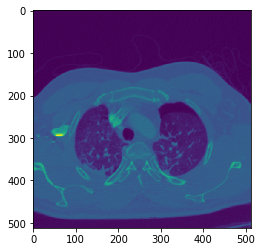

In [0]:
!pip install dicom
import dicom
import numpy
import matplotlib.pyplot as plt


dcmFiles = []
for filePath in glob.glob('/content/dataset/FUMPE/PAT001/train/*'):
  dcmFiles.append(filePath)

print(len(dcmFiles))
file = dicom.read_file(dcmFiles[0])

# Load dimensions based on the number of rows, columns, and slices (along the Z axis)
ConstPixelDims = (int(file.Rows), int(file.Columns),int(len(dcmFiles)))
print(ConstPixelDims)

# Load spacing values (in mm)
ConstPixelSpacing = (float(file.PixelSpacing[0]), float(file.PixelSpacing[1]), float(file.SliceThickness))
print(ConstPixelSpacing)

# The array is sized based on 'ConstPixelDims'
ArrayDicom = numpy.zeros(ConstPixelDims, dtype=file.pixel_array.dtype)

# loop through all the DICOM files
for dcmFile in dcmFiles:
    # read the file
    ds = dicom.read_file(dcmFile)
    # store the raw image data
    ArrayDicom[:, :,dcmFiles.index(dcmFile)] = ds.pixel_array
# print(ArrayDicom)  
img = ArrayDicom[:,:,1]#one slice 

plt.imshow(img, interpolation='nearest')
plt.show()


In [0]:
cp -R '/content/dataset/FUMPE/label-edited' '/content/gdrive'


cp: cannot create directory '/content/gdrive/label-edited': Operation not supported
